In [1]:
library('tidyverse')
library('ggrepel')
library('ggbeeswarm')
library('readxl')
library('limma')
library('edgeR')

org_opts <- options()

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.3.0      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
exp_matrix <-
    read_xlsx('counts raw chondrosarcoma.xlsx', sheet='TargetCountMatrix')

exp_matrix %>%
    head()

TargetName,NMS23-471 | 001 | S100B,NMS23-471 | 002 | S100B,NMS23-471 | 003 | S100B,NMS23-471 | 004 | S100B,NMS23-471 | 005 | CD68,NMS23-471 | 005 | CD3,NMS23-471 | 006 | CD68,NMS23-471 | 006 | CD3,NMS23-471 | 007 | CD68,⋯,S10-479 | 013 | CD3,S10-479 | 013 | S100,S10-479 | 014 | CD68,S10-479 | 014 | CD3,S10-479 | 014 | S100,S10-479 | 015 | CD68,S10-479 | 015 | CD3,S10-479 | 015 | S100,S10-479 | 016 | CD68,S10-479 | 016 | CD3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RFC3,1.245731,1.741101,1.319508,1.148698,1,1.000000,1,1,1.000000,⋯,1.000000,2.701920,1.000000,1,1.245731,1.319508,1.245731,1.000000,1.430969,1.888175
PSMB5,2.047673,1.148698,1.888175,1.245731,1,1.319508,1,1,1.000000,⋯,1.148698,2.605171,1.643752,1,1.430969,1.000000,1.000000,1.430969,1.643752,1.148698
POLD4,1.741101,1.000000,1.430969,1.515717,1,1.245731,1,1,1.000000,⋯,1.319508,4.324246,1.148698,1,1.782602,1.319508,1.319508,1.000000,1.430969,1.245731
MAP3K8,1.430969,1.245731,1.430969,1.000000,1,1.000000,1,1,1.000000,⋯,1.000000,2.701920,1.430969,1,2.111786,1.319508,1.000000,1.430969,1.319508,1.000000
IRF9,1.515717,1.148698,1.888175,1.148698,1,1.000000,1,1,1.148698,⋯,1.430969,4.042823,1.148698,1,1.741101,1.148698,1.148698,1.430969,1.000000,1.430969
PAX3,1.643752,1.148698,1.000000,1.515717,1,1.000000,1,1,1.000000,⋯,1.245731,3.758480,1.000000,1,2.352158,1.000000,1.148698,1.148698,1.148698,1.245731


In [3]:
tumor_vs_peritumor <-
    read_xlsx('normalized raw chondrosarcoma.xlsx', sheet='TargetCountMatrix', n_max=1, col_names=paste('c', 1:141, sep='_')) %>%
    t()

tumor_vs_peritumor %>%
    head()

c_1,tumor
c_2,tumor
c_3,tumor
c_4,tumor
c_5,peritumor
c_6,peritumor


In [4]:
sample_annotations <-
    tibble(
        `sample_desc`=exp_matrix %>% select(-`TargetName`) %>% colnames(),
        `region_type`=tumor_vs_peritumor %>% as.vector()
    ) %>%
    separate(`sample_desc`, c('sample_name', 'region_id', 'marker'), sep=' \\| ', remove=FALSE) %>%
    mutate(`marker`=case_when(
        `marker` == 'S100' ~ 'S100B',
        `marker` == 'DAPI' ~ 'S100B',
        TRUE ~ `marker`
    ))

sample_annotations %>%
    head()

sample_desc,sample_name,region_id,marker,region_type
<chr>,<chr>,<chr>,<chr>,<chr>
NMS23-471 | 001 | S100B,NMS23-471,001,S100B,tumor
NMS23-471 | 002 | S100B,NMS23-471,002,S100B,tumor
NMS23-471 | 003 | S100B,NMS23-471,003,S100B,tumor
NMS23-471 | 004 | S100B,NMS23-471,004,S100B,tumor
NMS23-471 | 005 | CD68,NMS23-471,005,CD68,peritumor
NMS23-471 | 005 | CD3,NMS23-471,005,CD3,peritumor


In [5]:
exp_tbl <-
    exp_matrix %>%
    pivot_longer(
        names_to='sample_desc',
        values_to='norm_exp',
        -`TargetName`
    ) %>%
    left_join(sample_annotations, by='sample_desc') %>%
    separate(`sample_desc`, c('sample_name', 'region_id', 'marker'), sep=' \\| ', remove=FALSE) %>%
    relocate(`region_type`, .after=`region_id`) %>%
    rename(`gene_symbol`=`TargetName`) %>%
    mutate(`marker`=case_when(
        `marker` == 'S100' ~ 'S100B',
        `marker` == 'DAPI' ~ 'S100B',
        TRUE ~ `marker`
    ))

exp_tbl %>%
    head()

gene_symbol,sample_desc,sample_name,region_id,region_type,marker,norm_exp
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
RFC3,NMS23-471 | 001 | S100B,NMS23-471,001,tumor,S100B,1.245731
RFC3,NMS23-471 | 002 | S100B,NMS23-471,002,tumor,S100B,1.741101
RFC3,NMS23-471 | 003 | S100B,NMS23-471,003,tumor,S100B,1.319508
RFC3,NMS23-471 | 004 | S100B,NMS23-471,004,tumor,S100B,1.148698
RFC3,NMS23-471 | 005 | CD68,NMS23-471,005,peritumor,CD68,1.000000
RFC3,NMS23-471 | 005 | CD3,NMS23-471,005,peritumor,CD3,1.000000


In [6]:
samples_of_interest <-
    sample_annotations %>%
    filter(
        `marker` == 'CD3',
        `sample_name` %in% c('S10-479', 'NMS22-289343')
    )

samples_of_interest

sample_desc,sample_name,region_id,marker,region_type
<chr>,<chr>,<chr>,<chr>,<chr>
NMS22-289343 | 001 | CD3,NMS22-289343,001,CD3,tumor
NMS22-289343 | 002 | CD3,NMS22-289343,002,CD3,tumor
NMS22-289343 | 003 | CD3,NMS22-289343,003,CD3,tumor
NMS22-289343 | 007 | CD3,NMS22-289343,007,CD3,peritumor
NMS22-289343 | 008 | CD3,NMS22-289343,008,CD3,peritumor
NMS22-289343 | 009 | CD3,NMS22-289343,009,CD3,peritumor
NMS22-289343 | 010 | CD3,NMS22-289343,010,CD3,peritumor
NMS22-289343 | 011 | CD3,NMS22-289343,011,CD3,peritumor
NMS22-289343 | 012 | CD3,NMS22-289343,012,CD3,peritumor


In [7]:
exp_matrix_dge <-
    exp_matrix %>%
    select(-`TargetName`) %>%
    select(all_of(samples_of_interest$`sample_desc`)) %>%
    as.matrix() %>%
    (function(x) {
        rownames(x) <- exp_matrix %>% select(`TargetName`) %>% pull
        
        x
    }) 

exp_matrix_dge

,NMS22-289343 | 001 | CD3,NMS22-289343 | 002 | CD3,NMS22-289343 | 003 | CD3,NMS22-289343 | 007 | CD3,NMS22-289343 | 008 | CD3,NMS22-289343 | 009 | CD3,NMS22-289343 | 010 | CD3,NMS22-289343 | 011 | CD3,NMS22-289343 | 012 | CD3,NMS22-289343 | 013 | CD3,⋯,S10-479 | 006 | CD3,S10-479 | 007 | CD3,S10-479 | 008 | CD3,S10-479 | 009 | CD3,S10-479 | 011 | CD3,S10-479 | 012 | CD3,S10-479 | 013 | CD3,S10-479 | 014 | CD3,S10-479 | 015 | CD3,S10-479 | 016 | CD3
RFC3,1.245731,1.000000,1,1.148698,1.148698,1.148698,1.000000,1.148698,1.000000,1.000000,⋯,2.930156,1.741101,1.430969,1.643752,2.297397,1.430969,1.000000,1.000000,1.245731,1.888175
PSMB5,1.000000,1.000000,1,1.000000,1.000000,1.148698,1.000000,1.000000,1.379730,1.000000,⋯,2.141127,1.430969,2.000000,4.441286,1.782602,2.091279,1.148698,1.000000,1.000000,1.148698
POLD4,1.148698,1.148698,1,1.000000,1.148698,1.148698,1.000000,1.000000,1.148698,1.000000,⋯,3.287504,2.701920,1.974350,2.701920,1.820564,1.319508,1.319508,1.000000,1.319508,1.245731
MAP3K8,1.000000,1.000000,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.148698,1.000000,⋯,3.987421,1.974350,1.515717,3.587214,1.430969,1.430969,1.000000,1.000000,1.000000,1.000000
IRF9,1.000000,1.000000,1,1.000000,1.000000,1.000000,1.000000,1.148698,1.000000,1.000000,⋯,4.057687,2.168944,2.047673,3.063887,3.613401,1.319508,1.430969,1.000000,1.148698,1.430969
PAX3,1.000000,1.000000,1,1.000000,1.148698,1.000000,1.000000,1.000000,1.148698,1.000000,⋯,2.766324,2.297397,1.245731,2.352158,1.741101,2.168944,1.245731,1.000000,1.148698,1.245731
APOB,1.000000,1.000000,1,1.000000,1.000000,1.430969,1.000000,1.148698,1.000000,1.000000,⋯,2.236854,1.515717,1.000000,3.245342,3.063887,1.515717,1.000000,1.000000,1.319508,1.319508
RASGRP2,1.000000,1.000000,1,1.000000,1.000000,1.000000,1.000000,1.148698,1.245731,1.000000,⋯,3.981072,2.220643,2.168944,1.643752,2.825235,1.741101,1.000000,1.000000,1.148698,1.430969
JAK2,1.000000,1.000000,1,1.000000,1.148698,1.000000,1.000000,1.000000,1.245731,1.000000,⋯,4.617893,2.168944,1.319508,2.550849,3.898060,1.551846,1.319508,1.245731,1.000000,1.515717
PLA2G4E,1.000000,1.000000,1,1.000000,1.148698,1.000000,1.000000,1.000000,1.245731,1.000000,⋯,4.169405,1.974350,1.000000,3.650186,1.515717,1.741101,1.245731,1.000000,1.148698,1.515717


In [8]:
exp_model <-
    samples_of_interest %>%
    model.matrix(data=., ~`region_type`)

exp_model

,(Intercept),region_typetumor
1,1,1
2,1,1
3,1,1
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0
10,1,0


In [9]:
dge <-
    DGEList(exp_matrix_dge) %>%
    calcNormFactors()

keep <- filterByExpr(dge, exp_model, min.count=.1)
dge <- dge[keep,, keep.lib.sizes=FALSE]
vdge <- voom(dge, exp_model)
all_fit <- lmFit(vdge, exp_model) %>% eBayes

In [10]:
all_table <-
    topTable(all_fit, adjust.method='bonferroni', n=nrow(exp_matrix_dge), sort.by='p') %>%
    rownames_to_column(var='gene') %>%
    as_tibble()

all_table %>%
    head(50)

Removing intercept from test coefficients



gene,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PTPN5,0.3560604,9.235601,5.720431,2.843566e-06,0.005587607,4.63517024
ILF3,0.4091520,9.241377,5.642428,3.549368e-06,0.006974508,4.42003873
IFNA8,0.5872581,9.216771,5.518666,5.047944e-06,0.009919211,4.09629907
MUC1,0.3824998,9.297802,5.381150,7.469317e-06,0.014677208,3.69112546
CCL26,0.4909290,9.200756,5.297774,9.473698e-06,0.018615816,3.49678639
NDUFB7,-0.8494173,10.523856,-4.919037,2.788905e-05,0.054801992,1.47809315
MIB1,0.3416312,9.201606,4.915164,2.819838e-05,0.055409818,2.47060743
IRF2,0.4903240,9.286436,4.908977,2.869957e-05,0.056394664,2.41503650
FANCB,0.4268682,9.318818,4.891489,3.016472e-05,0.059273671,2.38464263


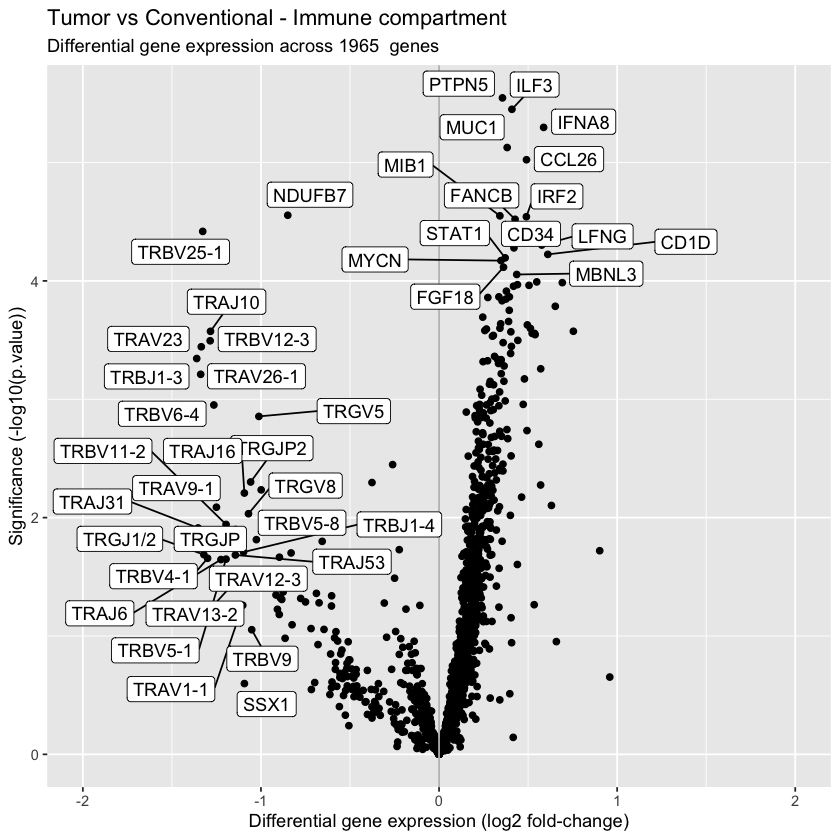

In [11]:
all_table %>%
    mutate(
        `label`=case_when(
            abs(`logFC`) >= 1 ~ str_replace_all(`gene`, ',.*', ''),
            -log10(`P.Value`) > 4 ~ str_replace_all(`gene`, ',.*', ''),
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf) +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='Tumor vs Conventional - Immune compartment',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes')
        ) +
        xlim(-2, 2)
